# 2 - Data Wrangling

**Author:** M. Görkem Ulutürk

**Date:** January, 2026

## Introduction

In the previous section of the project, we conducted initial data wrangling.
We've found that the data contains no duplicates; however, there are missing
values that we need to address.

Let's start by importing the modules and the data.

## Imports

In [1]:
import pickle
import sqlite3

import numpy as np
import pandas as pd
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (
    ConfusionMatrixDisplay,
    balanced_accuracy_score,
    confusion_matrix,
)
from sklearn.model_selection import (
    GridSearchCV,
    StratifiedKFold,
    train_test_split,
)

conn = sqlite3.connect(":memory:")

df = pd.read_csv("../data/raw/train.csv", encoding="utf-8")
df.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


## Data Cleaning & Validation

Recall that we've already checked for duplicates in the understanding and
planning phase, and we've found no duplicates. Let's start by converting the
column names to lowercase.

In [2]:
df.columns = df.columns.str.lower()

Let's also validate the data types.

In [3]:
print(df.dtypes)

passengerid      int64
survived         int64
pclass           int64
name               str
sex                str
age            float64
sibsp            int64
parch            int64
ticket             str
fare           float64
cabin              str
embarked           str
dtype: object


Data types are correct. Then, we can check for invalid values. For example,
we expect `survived` to be only 0 or 1.

In [4]:
df["sex"].value_counts(dropna=False)

sex
male      577
female    314
Name: count, dtype: int64

In [5]:
df["embarked"].value_counts(dropna=False)

embarked
S      644
C      168
Q       77
NaN      2
Name: count, dtype: int64

In [6]:
df[["survived", "pclass", "age", "sibsp", "parch", "fare"]].agg(["min", "max"])

,survived,pclass,age,sibsp,parch,fare
min,0,1,0.42,0,0,0.0000
max,1,3,80.00,8,6,512.3292


We see no invalid values among these columns except for `fare`, where there
exist rows with a `fare` amount of 0. We shall validate the `fare` column.

In [7]:
df["fare"].describe()

count    891.000000
mean      32.204208
std       49.693429
min        0.000000
25%        7.910400
50%       14.454200
75%       31.000000
max      512.329200
Name: fare, dtype: float64

Now, there isn't much we can do to validate the `fare` column. We can verify
that the most expensive ticket was in fact GBP 512.00, and some tickets were
handed out for free, as we see with the minimum. The mean ticket price also
makes sense, but besides these, there isn't much more we can do for the time
being.

Let's investigate the cabin column. Titanic accommodated luxurious cabins
with utmost comfort, especially for the first-class passengers. Below is a
cutaway diagram depicting these facilities.

<center><div><img src="https://upload.wikimedia.org/wikipedia/commons/thumb/0/0d/Olympic_%26_Titanic_cutaway_diagram.png/960px-Olympic_%26_Titanic_cutaway_diagram.png" alt="Titanic cutaway diagram" width="400"/></div></center>

> "The accomodation for first-class passengers is placed amidships and
> extends over five decks, the promenade (A), bridge (B), shelter (C), saloon
> (D), and upper (E) decks. *(Titanica, 2025a)*"

First-class accommodations were placed in cabins A through E, second and
third classes in D through G.

In our dataset, we see the following cases:

In [8]:
df.to_sql("titanic", conn, if_exists="replace", index=False)

query = """
SELECT DISTINCT(cabin) FROM titanic
WHERE cabin IS NOT NULL
LIMIT 30
"""

result = pd.read_sql_query(query, conn)
print(result)

          cabin
0           C85
1          C123
2           E46
3            G6
4          C103
5           D56
6            A6
7   C23 C25 C27
8           B78
9           D33
10          B30
11          C52
12          B28
13          C83
14          F33
15        F G73
16          E31
17           A5
18      D10 D12
19          D26
20         C110
21      B58 B60
22         E101
23        F E69
24          D47
25          B86
26           F2
27           C2
28          E33
29          B19


- Cabin numbers start with a capital English letter
- Some passengers accommodated multiple cabins
    - This is likely due to cabin numbers being shared between passenger
    groups, such as families (similar to the ticket number)
- Some passengers have cabin numbers starting with F, followed by another
cabin string, eg, F G73
- There exists a "T" cabin
- Some passengers don't have full cabin numbers but just the deck letter

Firstly, let's investigate the cabin T.

In [9]:
df.loc[df.cabin.str.contains("T"), "name"]

339    Blackwell, Mr. Stephen Weart
Name: name, dtype: str

There's only 1 passenger with this cabin number, Mr. Stephen Weart Blackwell.
According to Titanica (2025b), Mr. Blackwell was the only passenger with the
[cabin number T](https://www.encyclopedia-titanica.org/cabins.html), and this
number referred to the [boat
deck](https://www.encyclopedia-titanica.org/titanic-deckplans/boat-deck.html).
Thus, this is a legitimate entry.

Now, the entries like "F G73" are not mistakes either. The reason is that
this cabin number denotes the deck F, section G, cabin 73. We infer this
information from the [Titanic's
plans](https://www.encyclopedia-titanica.org/titanic-deckplans/f-deck.html)
themselves.

We're not yet sure whether cabin numbers themselves are correlated with the
survival of a passenger, though the deck information of the cabin number
could be. Therefore, we'll create a new column called `deck` that we'll fill
in by extracting it from the cabin number itself. This approach has 3 main
benefits:

1. We can fill in missing cabin numbers more reliably
2. Reduces model complexity by focusing on a broader feature
3. Reduces the risk of overfitting

In [10]:
def extract_deck(cabin: str) -> str | list:
    """
    Extracts the deck information (A, B, C, etc.) from the cabin number.

    Parameters
    ----------
    cabin : str
        Cabin number

    Returns
    -------
    str
        Cabin's deck
    """
    lst = cabin.split(" ")
    if len(lst) == 1:  # cabin number is of type letter + number
        return lst[0][0]
    if all([lst[0][0] == x[0] for x in lst]):
        return lst[0][0]
    if lst[0][0] == "F" and lst[1][0] in ["G", "E"]:
        return f"F-{lst[1][0]}"
    return lst

In [11]:
df.loc[df["cabin"].notna(), "cabin"].map(extract_deck).unique()

<StringArray>
['C', 'E', 'G', 'D', 'A', 'B', 'F', 'F-G', 'F-E', 'T']
Length: 10, dtype: str

We see that only F G000 and F E000 types of cabin numbers exist, while there
are other such possibilities, such as F R000. Although some sections, such as
F-J, did not contain any rooms, some sections that had rooms are still not
present in the dataset. Therefore, instead of distinguishing between a deck's
sections, we'll just use the main deck string and exclude the section.

In [12]:
def extract_deck_sectionless(cabin: str) -> str | list:
    """
    Extracts the deck information (A, B, C, etc.) from the cabin number.
    Ignores the sections such as F G73, F R171, etc. and only returns the deck
    letter.

    Parameters
    ----------
    cabin : str
        Cabin number

    Returns
    -------
    str
        Cabin's deck
    """
    lst = cabin.split(" ")
    if len(lst) == 1:
        return lst[0][0]
    if all([lst[0][0] == x[0] for x in lst]):
        return lst[0][0]
    if lst[0][0] == "F" and lst[1][0] in ["G", "E"]:
        return "F"  # same func as extract_deck func except for this line
    return lst


df["deck"] = df.loc[df["cabin"].notna(), "cabin"].map(extract_deck_sectionless)
df.loc[df["cabin"].notna(), ["cabin", "deck"]].head(10)

,cabin,deck
1,C85,C
3,C123,C
6,E46,E
10,G6,G
11,C103,C
21,D56,D
23,A6,A
27,C23 C25 C27,C
31,B78,B
52,D33,D


Notice that our assumption that the group tickets' cabin numbers were all in
the same deck was true for the non-missing data. We'll keep this assumption
in mind when filling in the missing values for the cabin column.

Lastly, let's check if the assumption that the first-class accommodations are
in decks A through E, and second and third classes in decks D through G.

In [13]:
invalid = (
    "(pclass == 1 and deck in ['F', 'G']) or "
    "(pclass == 2 and deck in ['A', 'B', 'C']) or "
    "(pclass == 3 and deck in ['A', 'B', 'C'])"
)

mismatched = df.dropna(subset=["cabin"]).query(invalid)
mismatched[["passengerid", "pclass", "deck", "cabin"]]

,passengerid,pclass,deck,cabin


There are no mismatches between passenger classes and their decks. Thus, the
`cabin` column contains no invalid entries.

Finally, we can validate the `sex` column using passenger names. To start
with, we can extract passenger titles from the `name` column. To do that, we
need to extract what titles are present in the dataset. What makes it easy in
our case is that titles end with a dot at the end of the word, so we can
filter by using that. Also, the names are consistent in formatting. Every
name string starts with the surname, followed by the title with a dot at the
end, and then the first and middle names follow. For example, Ward, Miss.
Anna.

In [14]:
titles = [
    df["name"]
    .dropna()
    .str.split()
    .explode()
    .loc[lambda s: s.str.contains(".", regex=False)]
    .unique()
    .tolist()
]

print(titles)

[['Mr.', 'Mrs.', 'Miss.', 'Master.', 'Don.', 'Rev.', 'Dr.', 'Mme.', 'Ms.', 'Major.', 'L.', 'Lady.', 'Sir.', 'Mlle.', 'Col.', 'Capt.', 'Countess.', 'Jonkheer.']]


Apart from one mistake in the titles ("L."), the rest of them are valid
titles in English, French, Italian, etc. The "L." comes from a shortened name
in the dataset. Below is an SQL query for the string "L."

In [15]:
df.to_sql("titanic", conn, if_exists="replace", index=False)
query = """
SELECT NAME FROM TITANIC
WHERE NAME LIKE "% L. %"
"""
result = pd.read_sql_query(query, conn)
print(result)

                                             name
0  Rothschild, Mrs. Martin (Elizabeth L. Barrett)


These titles can be explained as follows:
- ["Mr."](https://en.wikipedia.org/wiki/English_honorifics): for men,
regardless of marital status, who do not have another professional or
academic title
- ["Mrs."](https://en.wikipedia.org/wiki/English_honorifics): for married
women who do not have another professional or academic title
- ["Miss."](https://en.wikipedia.org/wiki/English_honorifics): for girls,
unmarried women, and (in the United Kingdom) married women who continue to
use their maiden name
- ["Master."](https://en.wikipedia.org/wiki/English_honorifics): for boys and
young men, or as a style for the heir to a Scottish peerage
- ["Don."](https://en.wikipedia.org/wiki/Don_(honorific)): commonly used in
Spain, Portugal, and Italy, it is an honorific prefix derived from the Latin
Dominus, meaning "lord" or "owner"
- ["Rev."](https://en.wikipedia.org/wiki/English_honorifics): used generally
for members of the Christian clergy, regardless of affiliation, but
especially in Catholic and Protestant denominations, for both men and women
- ["Dr."](https://en.wikipedia.org/wiki/English_honorifics): for the holder
of a doctoral degree in many countries, and for medical practitioners,
dentists, and veterinary surgeons
- ["Mme."](https://en.wikipedia.org/wiki/Title): the French abbreviation for
Madame, for women, a term of general respect or flattery, originally used
only for a woman of rank or authority
- ["Ms."](https://en.wikipedia.org/wiki/English_honorifics): for women,
regardless of marital status or when marital status is unknown
- ["Major."](https://en.wikipedia.org/wiki/Title): a military title
- ["Lady."](https://en.wikipedia.org/wiki/English_honorifics): for female
peers with the rank of baroness, viscountess, countess, and marchioness, or
the wives of men who hold the equivalent titles
- ["Sir."](https://en.wikipedia.org/wiki/English_honorifics): for men,
formally, if they have a British knighthood or if they are a baronet
- ["Mlle."](https://en.wikipedia.org/wiki/Mademoiselle_(title)): is a French
courtesy title traditionally given to an unmarried woman
- ["Col."](https://en.wikipedia.org/wiki/Title): a military title
- ["Capt."](https://en.wikipedia.org/wiki/Title): a military title or a
ship's highest responsible officer acting on behalf of the ship's owner
- ["Countess."
](https://dictionary.cambridge.org/dictionary/english/countess): a woman of
high social rank, or the wife of a count or earl
- ["Jonkheer."](https://en.wikipedia.org/wiki/Jonkheer): is literally
translated as 'young lord' in Dutch

(Paraphrased or directly quoted from the references)

Let's now create a column `title` from the names.

In [16]:
titles = [
    "Mr.",
    "Mrs.",
    "Miss.",
    "Master.",
    "Don.",
    "Rev.",
    "Dr.",
    "Mme.",
    "Ms.",
    "Major.",
    "Lady.",
    "Sir.",
    "Mlle.",
    "Col.",
    "Capt.",
    "Countess.",
    "Jonkheer.",
]


def extract_title(name: str) -> str | None:
    """
    Extracts the honorific title from the name string

    Parameters
    ----------
    name : str
        Passenger name

    Returns
    -------
    str | None
        Honorific title
    """
    str_list = name.split(" ")
    for _str in str_list:
        if _str in titles:
            return _str
    return None

In [17]:
df["title"] = df["name"].apply(extract_title)

print(f"Missing title values count: {df.title.isna().sum()}")
df[["name", "title"]].head(10)

Missing title values count: 0


,name,title
0,"Braund, Mr. Owen Harris",Mr.
1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",Mrs.
2,"Heikkinen, Miss. Laina",Miss.
3,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",Mrs.
4,"Allen, Mr. William Henry",Mr.
5,"Moran, Mr. James",Mr.
6,"McCarthy, Mr. Timothy J",Mr.
7,"Palsson, Master. Gosta Leonard",Master.
8,"Johnson, Mrs. Oscar W (Elisabeth Vilhelmina Berg)",Mrs.
9,"Nasser, Mrs. Nicholas (Adele Achem)",Mrs.


We understand that every name entry in the database contains a title and that
we had no errors extracting these titles.

Now, we can cross-reference titles with their respective genders. Note that
some of the titles in our dataset are gender-neutral. Thus, we'll only check
for the ones that are gender-specific initially.

In [18]:
pd.crosstab(df["sex"], df["title"])

title,Capt.,Col.,Countess.,Don.,Dr.,Jonkheer.,Lady.,Major.,Master.,Miss.,Mlle.,Mme.,Mr.,Mrs.,Ms.,Rev.,Sir.
sex,,,,,,,,,,,,,,,,,
female,0,0,1,0,1,0,1,0,0,182,2,1,0,125,1,0,0
male,1,2,0,1,6,1,0,2,40,0,0,0,517,0,0,6,1


We see that the gender-specific titles all match a passenger's sex. On the
other hand, we cannot methodically check for gender-neutral honorifics, and
the only way to verify those would be to individually research the passengers
with these titles. This verification is out of the scope of this project and
will not be needed for our purposes. Therefore, we deem that we've verified
the `sex` column using the passenger titles we've extracted from their names.

## Missing Values

Now that we've validated our data, let's proceed with filling the missing
values in.

In [19]:
na_counts = df.isna().sum()
na_counts[na_counts > 0]

age         177
cabin       687
embarked      2
deck        687
dtype: int64

### Embarked column

We'll start with the `embarked` column. Referring back to the data dictionary
we've provided in the notebook `Understanding & Planning`, `embarked` column
refers to the port of embarkation, meaning where they boarded the Titanic.
The three possible values this column takes are `C` for Cherbourg, France,
`Q` for Queenstown, Ireland, and `S` for Southampton, England.

> Titanic first departed from Southampton, England. It made two port calls,
> the first being Queenstown, Ireland, and the second being Cherbourg,
> France. This route was popular among British ocean liners for the
> Southampton-New York route.
>
> *"Titanic's maiden voyage was intended to be the first of many
> trans-Atlantic crossings between Southampton and New York via Cherbourg and
> Queenstown on westbound runs."*
>
> (*Wikipedia contributors, 2025*).

Let's first see the passengers with missing boarding locations and then try
to make some connections to fill these missing values.

In [20]:
df[df["embarked"].isna()]

,passengerid,survived,pclass,name,sex,age,sibsp,parch,ticket,fare,cabin,embarked,deck,title
61,62,1,1,"Icard, Miss. Amelie",female,38.0,0,0,113572,80.0,B28,NaN,B,Miss.
829,830,1,1,"Stone, Mrs. George Nelson (Martha Evelyn)",female,62.0,0,0,113572,80.0,B28,NaN,B,Mrs.


Both passengers have first-class tickets for cabin "B28", and they share the
same ticket number. Therefore, they've traveled together. In this case, it
makes sense that they also boarded the liner together.

In [21]:
df[df.pclass == 1].groupby(by="embarked")["embarked"].value_counts()

embarked
C     85
Q      2
S    127
Name: count, dtype: int64

We see that the vast majority of the passengers with `pclass` as 1 embarked
from Southampton, followed by Cherbourg.

Considering the vast majority of 1st class passengers boarded the Titanic
from Southampton, we'll assign the `Embarked` as `S` for these passengers.

In [22]:
df["embarked"] = df["embarked"].fillna(value="S")
print(f"Missing embarked values count: {df.embarked.isna().sum()}")

Missing embarked values count: 0


### Age

Let's first save the missing age indices to a separate csv file so that we
can keep track of it during later stages.

In [23]:
na_ids = df.loc[df.age.isna(), "passengerid"]
na_ids.to_csv("../data/raw/na_ids.csv")

The dataset has 177 missing age values. Let's first investigate missing
values in the `age` column per title.

In [24]:
na_age_titles = df.loc[df.age.isna(), "title"].unique()
print(f"Titles with missing age entries: {na_age_titles}")

Titles with missing age entries: <StringArray>
['Mr.', 'Mrs.', 'Miss.', 'Master.', 'Dr.']
Length: 5, dtype: str


In [25]:
df.loc[df.title.isin(na_age_titles), "title"].value_counts()

title
Mr.        517
Miss.      182
Mrs.       125
Master.     40
Dr.          7
Name: count, dtype: int64

We observe that the titles with missing age values contain nonempty entries
as well. Therefore, we can use groupings to impute the missing age entries.
For the majority of the cases, we can just use the medians to fill the
missing values. However, we should handle some cases manually. For example,
Miss. title includes girls and unmarried woman and first-class passengers
often traveled with the family maids, who were often unmarried women.
Therefore, we'll determine some cases to handle first.

For titles Dr. and Master., we can impute using title medians. Let's start
with that first.

In [26]:
dr_median = df.loc[df.title == "Dr.", "age"].median()
df.loc[(df.title == "Dr.") & (df.age.isna()), "age"] = dr_median

master_median = df.loc[df.title == "Master.", "age"].median()
df.loc[(df.title == "Master.") & (df.age.isna()), "age"] = master_median

Next up, let's manually fill missing the young girl ages. We can filter by
title Miss. and `parch`. Recall that `parch` denotes the number of parents or
children onboard. Since Miss. title is exclusive to unmarried women and
having children without marriage was not common at all at the time, we can
assume that `parch` > 0 implies they have parents, which means that they are
girls or young women.

In [27]:
mask = (df.title == "Miss.") & (df.parch > 0)
young_girl_median = df.loc[mask, "age"].median()
df.loc[mask & (df.age.isna()), "age"] = young_girl_median

For the rest of the passengers, we can impute values with title and passenger
class medians. The reason we include the passenger class is simple.
First-class passengers were generally wealthy businessmen, who were generally
middle-aged or older, and third-class passengers were usually workers and
immigrants, who were younger.

In [28]:
df["age"] = df["age"].fillna(
    df.groupby(by=["title", "pclass"])["age"].transform("median")
)
print(f"Missing age values count: {df.age.isna().sum()}")

Missing age values count: 0


<div class="alert alert-block alert-info">
    <b>NOTE:</b> Although our methodology was solid, we may have introduced
    some noise to the dataset. In future versions, if a more careful
    procedure for preparing the data for model training is deemed necessary,
    this section can be improved.

Here are some improvement options:

1. Refine the method
2. Manually fill as much data as possible (some missing values from the
dataset can be found by research)
3. Automation or web scraping for filling as much data as possible.

</div>

Titanic has been a research area for many years, and through the collective
efforts of many brilliant minds, a lot of the missing data has been
recovered. Therefore, we can fill in the missing passenger ages in case they
are known but not present in our dataset. This kind of improvement is out of
our scope, though.

### Cabin

As we've briefly mentioned before, filling individual cabin numbers is a
near-impossible task with a high risk of introducing a lot of noise. Instead,
we can fill the `deck` column we've added. To do this, we can make use of the
fact that decks A-E included first-class cabins while decks D-G included
second and third-class cabins.

We can group decks by `pclass` and `fare` to fill in the missing values.
However, one issue with the `fare` column is that it is not passenger-based
but rather ticket-based. For example, a family can buy a single ticket with a
whole sum fare, and both the ticket number and the fare amount will be the
same for every member of the family.

We could first resolve the `fare` column before imputation. However, the
difficulties with the fare are

1. The training dataset may not include every member with the same ticket
number.
    - For example, if a family of 5 bought a 5-person ticket, but our
    training data includes only 4 of the members, then doing a basic
    calculation like `fare = fare / 4` for each passenger will result in an
    incorrect ticket cost.
2. Some tickets could be handed out for </b>ee or with discounts, which we
have no way of knowing.
3. Apparently, ticket discounts were applied based on age: adults, children,
and babies had different ticket costs.
    - Since we've imputed 177 missing age values, we may introduce more noise
    by feature extraction for `age`.

On the other hand, not dealing with the `fare` column can also misguide us in
imputation. Before we make a strategy, let's first fill in `deck` column
based on `ticket`: if a passenger with an empty `deck` column shares his/her
ticket with another passenger with a valid `deck` value, we can use this for
imputation.

In [29]:
def fill_same_ticket_decks():
    na_count_before = df.deck.isna().sum()

    ticket_deck_mode = (
        df.dropna(subset=["deck"])
        .groupby(by="ticket")["deck"]
        .agg(lambda x: x.value_counts().idxmax())
    )

    df["deck"] = df["deck"].fillna(df["ticket"].map(ticket_deck_mode))

    na_count_after = df.deck.isna().sum()

    print(f"Filled {na_count_before - na_count_after} missing values.")

In [30]:
fill_same_ticket_decks()

Filled 11 missing values.


We've only filled 11 missing values. There are still 676 missing values. Now,
we need to make a decision.

All things considered, imputing `deck` by using `pclass` and `fare` seems to
be the most logical approach. Due to how each cabin (and therefore its
corresponding deck) was designed to target a specific wealth group, there
should be a natural distinction between decks. Hence, we can use a predictive
model for imputation. In our case, a random forest classifier works the best
since

- Random forests are resistant to nonlinearity and outliers
- Doesn't require encoding (which can introduce nonexistent ordering between
categories)
- Should work well with the `fare` despite our difficulties making inferences

In [31]:
ticket_counts = df["ticket"].map(df["ticket"].value_counts())
family_size = df["sibsp"] + df["parch"] + 1

group_size = np.where(
    ticket_counts > 1, np.maximum(ticket_counts, family_size), family_size
)

df["fare_per_person"] = df["fare"] / group_size

df[["fare", "fare_per_person"]].head(10)

,fare,fare_per_person
0,7.2500,3.62500
1,71.2833,35.64165
2,7.9250,7.92500
3,53.1000,26.55000
4,8.0500,8.05000
5,8.4583,8.45830
6,51.8625,51.86250
7,21.0750,4.21500
8,11.1333,3.71110
9,30.0708,15.03540


What we essentially do above is as follows:

1. We first count how many passengers share the same ticket number
2. Then, we estimate group size using `sibsp` and `parch` columns
3. If a ticket is shared, we split the fare among either the ticket count or
the group size
4. If a ticket is not shared, the fare is split between family members only
5. Compute each passenger's fare per person by `fare / group_size`

Of course, we're still not able to capture every fare per person value
accurately. For example, one case our code doesn't account for is when a
passenger in our training data doesn't share his/her ticket number with
someone else, but in reality, their peer is in the testing data (which we do
not have access to until we train our model). We've accounted for such cases
and decided to use `parch` and `sibsp` for solving this issue, but it remains
if the person they shared their ticket with does not fall into those two
categories, such as a maid not counted for either of those columns, and our
code will still not capture them.

The bottom line here is that we cannot deterministically capture every single
"fare per person" amount; we can only approximate. Therefore, the tree
classifier we'll build for imputing the decks will also be subject to these
approximations. As a result, we cannot really expect such great accuracy. On
the contrary, with these few predictor variables and a small sample size, a
higher accuracy would hint at extreme overfitting, data leakage, etc., rather
than hinting at discovering relations between feature and target variables
for imputation.

Let's proceed with developing our model.

In [32]:
seed = 6

rf_data = df.drop("cabin", axis=1).dropna(axis=0)
rf_data = rf_data[rf_data["deck"] != "T"]

X = rf_data[["fare_per_person", "pclass"]]
y = rf_data["deck"]

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.20, stratify=y, random_state=seed
)

print(X_train.shape, y_test.shape)

(171, 2) (43,)


In [33]:
rf = RandomForestClassifier(n_jobs=-1, random_state=seed)

cv = StratifiedKFold(n_splits=3, shuffle=True, random_state=seed)

param_grid = {
    "n_estimators": np.arange(10, 101, 10),
    "max_depth": np.arange(3, 16, 2),
    "min_samples_split": [2, 3, 4],
    "min_impurity_decrease": [0, 0.000125, 0.00025, 0.005],
}

clf = GridSearchCV(
    estimator=rf,
    param_grid=param_grid,
    scoring="balanced_accuracy",
    n_jobs=-1,
    refit=True,
    cv=cv,
    verbose=1,
)

clf.fit(X_train, y_train)

Fitting 3 folds for each of 840 candidates, totalling 2520 fits


,"estimator estimator: estimator objectThis is assumed to implement the scikit-learn estimator interface.Either estimator needs to provide a ``score`` function,or ``scoring`` must be passed.",RandomForestC...andom_state=6)
,"param_grid param_grid: dict or list of dictionariesDictionary with parameters names (`str`) as keys and lists ofparameter settings to try as values, or a list of suchdictionaries, in which case the grids spanned by each dictionaryin the list are explored. This enables searching over any sequenceof parameter settings.","{'max_depth': array([ 3, 5..., 11, 13, 15]), 'min_impurity_decrease': [0, 0.000125, ...], 'min_samples_split': [2, 3, ...], 'n_estimators': array([ 10, ...80, 90, 100])}"
,"scoring scoring: str, callable, list, tuple or dict, default=NoneStrategy to evaluate the performance of the cross-validated model onthe test set.If `scoring` represents a single score, one can use:- a single string (see :ref:`scoring_string_names`);- a callable (see :ref:`scoring_callable`) that returns a single value;- `None`, the `estimator`'s :ref:`default evaluation criterion ` is used.If `scoring` represents multiple scores, one can use:- a list or tuple of unique strings;- a callable returning a dictionary where the keys are the metric names and the values are the metric scores;- a dictionary with metric names as keys and callables as values.See :ref:`multimetric_grid_search` for an example.",'balanced_accuracy'
,"n_jobs n_jobs: int, default=NoneNumber of jobs to run in parallel.``None`` means 1 unless in a :obj:`joblib.parallel_backend` context.``-1`` means using all processors. See :term:`Glossary `for more details... versionchanged:: v0.20 `n_jobs` default changed from 1 to None",-1
,"refit refit: bool, str, or callable, default=TrueRefit an estimator using the best found parameters on the wholedataset.For multiple metric evaluation, this needs to be a `str` denoting thescorer that would be used to find the best parameters for refittingthe estimator at the end.Where there are considerations other than maximum score inchoosing a best estimator, ``refit`` can be set to a function whichreturns the selected ``best_index_`` given ``cv_results_``. In thatcase, the ``best_estimator_`` and ``best_params_`` will be setaccording to the returned ``best_index_`` while the ``best_score_``attribute will not be available.The refitted estimator is made available at the ``best_estimator_``attribute and permits using ``predict`` directly on this``GridSearchCV`` instance.Also for multiple metric evaluation, the attributes ``best_index_``,``best_score_`` and ``best_params_`` will only be available if``refit`` is set and all of them will be determined w.r.t this specificscorer.See ``scoring`` parameter to know more about multiple metricevaluation.See :ref:`sphx_glr_auto_examples_model_selection_plot_grid_search_digits.py`to see how to design a custom selection strategy using a callablevia `refit`.See :ref:`this example`for an example of how to use ``refit=callable`` to balance modelcomplexity and cross-validated score... versionchanged:: 0.20 Support for callable added.",True
,"cv cv: int, cross-validation generator or an iterable, default=NoneDetermines the cross-validation splitting strategy.Possible inputs for cv are:- None, to use the default 5-fold cross validation,- integer, to specify the number of folds in a `(Stratified)KFold`,- :term:`CV splitter`,- An iterable yielding (train, test) splits as arrays of indices.For integer/None inputs, if the estimator is a classifier and ``y`` iseither binary or multiclass, :class:`StratifiedKFold` is used. In allother cases, :class:`KFold` is used. These splitters are instantiatedwith `shuffle=False` so the splits will be the same across calls.Refer :ref:`User Guide ` for the variouscross-validation strategies that can be used here... versionchanged:: 0.22 ``cv`` default value if None changed from 3-fold to 5-fold.",StratifiedKFo... shuffle=True)
,"verbose verbose: intControls the verbos

In [34]:
y_pred = clf.predict(X_test)

print(f"Accuracy: {balanced_accuracy_score(y_test, y_pred)}")

print(clf.best_params_)

Accuracy: 0.7233908948194662
{'max_depth': np.int64(7), 'min_impurity_decrease': 0, 'min_samples_split': 2, 'n_estimators': np.int64(60)}


72.34% accuracy is sufficient for our case. We won't go much deeper into why,
but one quick metric we could obtain is to train a base model with the
following logic:

- Predict decks A-E for `pclass == 1`
- Predict decks D-G for `pclass == 2` or `pclass == 3`

Let's also investigate the confusion matrix.

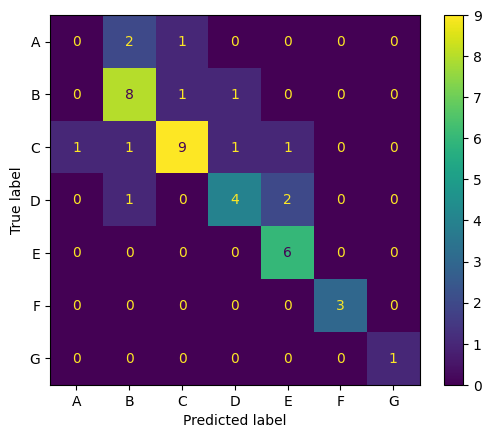

In [35]:

cm = confusion_matrix(y_test, y_pred, labels=clf.classes_)

disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=clf.classes_)

disp.plot()

Here's a breakdown of the confusion matrix:

- Deck A is always confused with its neighbors
- Deck B is often predicted correctly, model's accuracy is quite high
- Deck C is similar to deck B, mostly correct but sometimes confused with its
neighbors
- Deck D neighbor confusion is a bit higher than deck B and C
- Deck E is 100% accurate, could even be overfit
- Deck F is the same case as deck E
- Deck G has only 1 occurence which was predicted correctly

Decks are often confused with their neighbors. This hints at a possible
improvement in feature engineering stage: grouping decks into classes. For
example, we can group decks into "Higher", "Middle", and "Lower" classes such
as

```python
{
  "higher": ["A, B"],
  "middle": ["C", "D", "E"],
  "lower": ["F", "G"]
}
```

However, this is out of our scope for this section. What we consider here is
to whether use this model for imputing missing `deck` values or not. We'll
proceed with doing so. For that, we'll retrain the model with `best_params_`
obtained from GridSearchCV with the whole data and use `predict_proba`. We'll
assign a predicted deck to a passenger only when the model's confidence is
above our threshold. We can start with 60% and tune this parameter later.

In [36]:
model = RandomForestClassifier(random_state=42, n_jobs=-1, **clf.best_params_)

model.fit(X, y)

,"n_estimators n_estimators: int, default=100The number of trees in the forest... versionchanged:: 0.22 The default value of ``n_estimators`` changed from 10 to 100 in 0.22.",np.int64(60)
,"criterion criterion: {""gini"", ""entropy"", ""log_loss""}, default=""gini""The function to measure the quality of a split. Supported criteria are""gini"" for the Gini impurity and ""log_loss"" and ""entropy"" both for theShannon information gain, see :ref:`tree_mathematical_formulation`.Note: This parameter is tree-specific.",'gini'
,"max_depth max_depth: int, default=NoneThe maximum depth of the tree. If None, then nodes are expanded untilall leaves are pure or until all leaves contain less thanmin_samples_split samples.",np.int64(7)
,"min_samples_split min_samples_split: int or float, default=2The minimum number of samples required to split an internal node:- If int, then consider `min_samples_split` as the minimum number.- If float, then `min_samples_split` is a fraction and `ceil(min_samples_split * n_samples)` are the minimum number of samples for each split... versionchanged:: 0.18 Added float values for fractions.",2
,"min_samples_leaf min_samples_leaf: int or float, default=1The minimum number of samples required to be at a leaf node.A split point at any depth will only be considered if it leaves atleast ``min_samples_leaf`` training samples in each of the left andright branches. This may have the effect of smoothing the model,especially in regression.- If int, then consider `min_samples_leaf` as the minimum number.- If float, then `min_samples_leaf` is a fraction and `ceil(min_samples_leaf * n_samples)` are the minimum number of samples for each node... versionchanged:: 0.18 Added float values for fractions.",1
,"min_weight_fraction_leaf min_weight_fraction_leaf: float, default=0.0The minimum weighted fraction of the sum total of weights (of allthe input samples) required to be at a leaf node. Samples haveequal weight when sample_weight is not provided.",0.0
,"max_features max_features: {""sqrt"", ""log2"", None}, int or float, default=""sqrt""The number of features to consider when looking for the best split:- If int, then consider `max_features` features at each split.- If float, then `max_features` is a fraction and `max(1, int(max_features * n_features_in_))` features are considered at each split.- If ""sqrt"", then `max_features=sqrt(n_features)`.- If ""log2"", then `max_features=log2(n_features)`.- If None, then `max_features=n_features`... versionchanged:: 1.1 The default of `max_features` changed from `""auto""` to `""sqrt""`.Note: the search for a split does not stop until at least onevalid partition of the node samples is found, even if it requires toeffectively inspect more than ``max_features`` features.",'sqrt'
,"max_leaf_nodes max_leaf_nodes: int, default=NoneGrow trees with ``max_leaf_nodes`` in best-first fashion.Best nodes are defined as relative reduction in impurity.If None then unlimited number of leaf nodes.",None
,"min_impurity_decrease min_impurity_decrease: float, default=0.0A node will be split if this split induces a decrease of the impuritygreater than or equal to this value.The weighted impurity decrease equation is the following:: N_t / N * (impurity - N_t_R / N_t * right_impurity - N_t_L / N_t * left_impurity)where ``N`` is the total number of samples, ``N_t`` is the number ofsamples at the current node, ``N_t_L`` is the number of samples in theleft child, and ``N_t_R`` is the number of samples in the right child.``N``, ``N_t``, ``N_t_R`` and ``N_t_L`` all refer to the weighted sum,if ``sample_weight`` is passed... versionadded:: 0.19",0
,"bootstrap bootstrap: bool, default=TrueWhether bootstrap samples are used when building trees. If False, thewhole dataset is used to build each tree.",True
,"oob_score oob_score: bool or callable, default=FalseWhether to use out-of-bag samples to estimate the generalization score.By default, :func:`~sklearn.metrics.accuracy_score` is used.Provide a callable with sig

Let's also `pickle` this model for future use.

In [37]:

with open("../models/deck_imputer.pkl", "wb") as file:
    pickle.dump(model, file)

Now, we can impute the missing decks for passengers who share their tickets
first. We'll make it so that we'll only impute the first passenger
corresponding to the duplicated ticket, then set the decks for the rest of
the passengers with the same ticket number as the first passenger.

In [38]:
def impute_decks(
    data: pd.DataFrame, passenger_idx: pd.Series, threshold: float = 0.6
) -> None:
    """
    Imputes the missing deck information of the specified passengers.

    Parameters
    ----------
    data : pd.DataFrame
        Original dataframe
    passenger_idx : pd.Series
        Passenger indices series
    threshold : float
        Minimum confidence level requirement for RandomForestClassifier
        imputation

    Returns
    -------
    None
        Imputes the values directly into the given pd.DataFrame object
    """
    X_missing = data.loc[passenger_idx, ["fare_per_person", "pclass"]]

    proba = model.predict_proba(X_missing)
    classes = model.classes_

    max_proba = proba.max(axis=1)
    pred_idx = proba.argmax(axis=1)
    pred_labels = classes[pred_idx]

    na_count_before = data.deck.isna().sum()

    df.loc[passenger_idx, "deck"] = np.where(
        max_proba >= threshold, pred_labels, np.nan
    )

    na_count_after = data.deck.isna().sum()

    print(f"Imputed {na_count_before - na_count_after} missing values.")

    return None

In [39]:
impute_decks(data=df, passenger_idx=df.ticket.duplicated(keep="first"))

Imputed 89 missing values.


Now, we can set the decks of the passengers with the same tickets again.

In [40]:
fill_same_ticket_decks()

Filled 80 missing values.


In [41]:
df.deck.isna().sum()

np.int64(507)

We still have 507 missing values to deal with. For the rest of the data, we
can lower the threshold to 0, perform a check on whether `pclass` matches the
assigned deck, and apply the same deck to the other ticket holders as we just
did.

In [42]:
impute_decks(
    data=df, passenger_idx=df.ticket.duplicated(keep="first"), threshold=0.0
)

invalid = (
    "(pclass == 1 and deck in ['F', 'G']) or "
    "(pclass == 2 and deck in ['A', 'B', 'C']) or "
    "(pclass == 3 and deck in ['A', 'B', 'C'])"
)

mismatched = df.dropna(subset=["deck"]).query(invalid)
mismatched[["passengerid", "pclass", "deck"]]

Imputed 28 missing values.


,passengerid,pclass,deck


We don't have any inconsistencies regarding `pclass` and `deck` mismatches.
Therefore, we can proceed with imputing the rest of the values.

In [43]:
fill_same_ticket_decks()

print(f"Missing deck values count: {df.deck.isna().sum()}")

Filled 21 missing values.
Missing deck values count: 458


Now, we have 458 passengers left who do not share their ticket with anyone
else. We'll impute these values and then check whether there's an
inconsistency.

In [44]:
impute_decks(data=df, passenger_idx=df.deck.isna(), threshold=0.0)

print(f"Missing deck values count: {df.deck.isna().sum()}")

invalid = (
    "(pclass == 1 and deck in ['F', 'G']) or "
    "(pclass == 2 and deck in ['A', 'B', 'C']) or "
    "(pclass == 3 and deck in ['A', 'B', 'C'])"
)

mismatched = df.dropna(subset=["cabin"]).query(invalid)
mismatched[["passengerid", "pclass", "deck", "cabin"]]

Imputed 458 missing values.
Missing deck values count: 0


,passengerid,pclass,deck,cabin


We've successfully imputed the `deck` column without any inconsistencies!
We'll save the modified data for future use in our EDA and model building.

In [45]:
df.to_csv(
    "../data/modified/cleaned.csv", encoding="utf-8", header=True, index=False
)

## Takeaways

In the data wrangling phase, we've completed the following procedures:

1. Imported the data
2. Converted column names to lowercase letters
3. Validated data types
4. Extracted a new column `deck` from `cabin` column
5. Extracted a new column `title` from `name` column
6. Validated the data (except for the `fare` column, read the related section
for more details)
7. Imputed 2 `embarked`, 177 `age`, and 687 `deck` values

Our strategy for imputation was as follows:

1. In `embarked` column, there were only 2 missing values. Both passengers
shared the same ticket number, which indicated that they probably both
embarked from the same place. We checked which port was the most common among
first-class passengers to embark from. Then, we assigned that value to the
missing entries.
2. In `age` column, we followed different strategies for handling missing
values. For example, we handled the "Master." title case separately since
that title is specific to a certain age group. We sliced the passengers into
groups using their titles, and for the rest, we used a title and passenge
class based median calculation and assigned the value to the missing entries.
3. Instead of imputing the `cabin` column, we decided to impute the `deck`
column as it would introduce less noise. We built a random forest classifier
and trained it on a feature-engineered column `fare_per_person`. We
hyperparameter-tuned this model and used it to impute the missing values. We
also checked whether there were inconsistencies, for example, a first-class
passenger being assigned to deck G, but there were none.

We saved the resulting `pd.DataFrame` object as a new dataset under the
directory `data/modified/cleaned.csv`, which we'll use in the upcoming
sections.

Throughout this section, we had to make certain decisions on our methodology
for validating the existing data and imputing the missing data. We've stated
the difficulties, possible consequences of our choices, and what can be
improved with our work if a refinement is needed in the future. Overall, I'm
satisfied with this level of work. We've stayed realistic, made solid steps
towards obtaining a cleaner dataset, and we've been conscious of the
decisions we had to make.

## References

- countess. (2026).
https://dictionary.cambridge.org/dictionary/english/countess
- Research guide D1: RMS Titanic: Fact sheet. (n.d.). Royal Museums
Greenwich.
https://www.rmg.co.uk/collections/research-guides/research-guide-d1-rms-titanic-fact-sheet
- Titanic Deckplans : RMS Titanic : Plan of Boat Deck. (n.d.).
https://www.encyclopedia-titanica.org/titanic-deckplans/boat-deck.html
- Titanic Deckplans : RMS Titanic : Plan of F Deck. (n.d.).
https://www.encyclopedia-titanica.org/titanic-deckplans/f-deck.html
- Titanica, E. (2025a, September 3). Olympic & Titanic : Passenger
Accommodation.
https://www.encyclopedia-titanica.org/passenger-accommodation.html
- Titanica, E. (2025b, September 16). Cabin Allocations.
https://www.encyclopedia-titanica.org/cabins.html
- Wikipedia contributors. (n.d.). File:Olympic & Titanic cutaway diagram.png
- Wikipedia.
https://en.wikipedia.org/wiki/File:Olympic_%26_Titanic_cutaway_diagram.png
- Wikipedia contributors. (2025a, March 1). Mademoiselle (title). Wikipedia.
https://en.wikipedia.org/wiki/Mademoiselle_(title)
- Wikipedia contributors. (2025b, September 28). Don (honorific). Wikipedia.
https://en.wikipedia.org/wiki/Don_(honorific)
- Wikipedia contributors. (2025c, October 10). Jonkheer. Wikipedia.
https://en.wikipedia.org/wiki/Jonkheer
- Wikipedia contributors. (2025d, December 5). English honorifics. Wikipedia.
https://en.wikipedia.org/wiki/English_honorifics
- Wikipedia contributors. (2025e, December 17). First-class facilities of the
Titanic. Wikipedia.
https://en.wikipedia.org/wiki/First-class_facilities_of_the_Titanic
- Wikipedia contributors. (2025f, December 19). Title. Wikipedia.
https://en.wikipedia.org/wiki/Title Wikipedia contributors. (2025g, December
21). Titanic. Wikipedia. https://en.wikipedia.org/wiki/Titanic